# Extrinsic Calibration from 2D-2D Correspondences

### Goal

Given a set of 2D-2D correspondences between two camera images of known intrinsic parameters $K$, this notebook estimates their relative pose $R, t$.

* Input
  * $x_1$: 2D points in Cam1 image
  * $x_2$: 2D points in Cam2 image
  * $K_1$: Cam1 intrinsic parameter
  * $K_2$: Cam2 intrinsic parameter
* Output
  * $R, t$: Relative pose satisfying $X_2 = R X_1 + t$ (i.e., Cam1 is the world coordinate system)


Note:
1. If the two cameras share a single intrinsic parameter (e.g., structure-from-motion, or physically-identical cameras),
use `cv2.findEssentialMat()` and `cv2.recoverPose()`.


## Libraries

In [1]:
%matplotlib notebook
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera
from pycalib.calib import lookat


## Synthetic data



In [2]:
# 3D points
# X_gt = (np.random.rand(16, 3) - 0.5)*5 + [0, 0, 10] # random points centered at [0, 0, 10]
X_gt = np.array(np.meshgrid(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5), np.linspace(9, 11, 3))).reshape((3, -1)).T  # 3D grid points

# Camera poses
R1_gt = np.eye(3)
t1_gt = np.zeros(3).reshape((3,1))
R2_gt, t2_gt = lookat(np.array([1,0,0]), np.array([0,0,10]), np.array([0,1,0]))
rvec1_gt = cv2.Rodrigues(R1_gt)[0]
rvec2_gt = cv2.Rodrigues(R2_gt)[0]

# Camera intrinsics
K1 = np.array([[600, 0, 320], [0, 600, 240], [0, 0, 1]]).astype(np.float)  # VGA camera
K2 = np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]]).astype(np.float)  # 720p camera
K2 = K1

# 2D corresponding points
x1 = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1, None)[0].reshape((-1, 2))
x2 = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2, None)[0].reshape((-1, 2))

# Verify triangulation
Y = cv2.triangulatePoints(K1 @ np.hstack((R1_gt, t1_gt)), K2 @ np.hstack((R2_gt, t2_gt)), x1.T, x2.T)
Y = Y[:3] / Y[3,:]
assert np.allclose(0, X_gt - Y.T)

# Verify z > 0 at each camera
assert np.all(X_gt[:, 2] > 0)
assert np.all((R2_gt @ X_gt.T + t2_gt)[2, :] > 0)

## Essential matrix

* Input: $K_1$, $K_2$, $x_1$, $x_2$
* Output: $E$ satisfying $ (K_2^{-1}\tilde{x}_2)^\top E (K_1^{-1} \tilde{x}_1) = 0$ 

In [3]:
# x1, x2 -> F
F, _ = cv2.findFundamentalMat(x1, x2, cv2.FM_8POINT)

x1h = cv2.convertPointsToHomogeneous(x1).reshape((-1,3)).T
x2h = cv2.convertPointsToHomogeneous(x2).reshape((-1,3)).T
n1 = np.linalg.inv(K1) @ x1h
n2 = np.linalg.inv(K2) @ x2h

# check F error
F_err = x2h.T @ F @ x1h
F_err = np.mean(F_err**2)
print(f'F error = {F_err}')

# F, K1, K2 -> E
# x2.T F x1 = 0 <-> n2.T E n1 = 0 where n1 = K1^-1 x1
E = K2.T @ F @ K1
E = E / np.linalg.norm(E)

# check E error
E_err = np.mean((n2.T @ E @ n1)**2)
print(f'E error = {E_err}')   # should be identical to F_err




F error = 75.02142835105984
E error = 0.020211630539419753


## Decompose $R, t$ from $E$

Given an essentinal matrix $E$, we have four possible solutions
* $R, t$,
* $R, -t$,
* $R', t$, and
* $R', -t$.

We can find the collect one by checking if the triangulated 3D points appear in front of the both cameras.



In [4]:
R2a, R2b, t2 = cv2.decomposeEssentialMat(E)
R1 = np.eye(3)
t1 = np.zeros((3,1))

def z_count(R1, t1, R2, t2, K1, K2, x1, x2):
    """
    Count number of points appeared in front of the cameras
    """
    P1 = K1 @ np.hstack((R1, t1))
    P2 = K2 @ np.hstack((R2, t2))
    Xh1 = cv2.triangulatePoints(P1, P2, x1, x2)
    Xh1 /= Xh1[3,:]
    z1 = np.sum(Xh1[2,:]>0)  # num of positive z points in Cam1 coordinate system
    Xh2 = R2 @ Xh1[:3,:] + t2
    z2 = np.sum(Xh2[2,:]>0)  # num of positive z points in Cam2 coordinate system
    return (z1 + z2), Xh1[:3,:]

zmax = -1
for R2x, t2x in [[R2a, t2], [R2a, -t2], [R2b, t2], [R2b, -t2]]:
    z, Xx = z_count(R1, t1, R2x,  t2x, K1, K2, x1.T, x2.T)
    if zmax < z:
        zmax = z
        R2_est = R2x
        t2_est = t2x
        X_est = Xx


print('R2 = ', R2_est)
print('t2 = ', t2_est)

print('R2_gt = ', R2_gt)  # ground truth
print('t2_gt = ', t2_gt)  # ground truth


R2 =  [[ 9.95037186e-01  1.91065792e-08  9.95037580e-02]
 [-5.21928312e-09  1.00000000e+00 -1.39825857e-07]
 [-9.95037580e-02  1.38612589e-07  9.95037186e-01]]
t2 =  [[-9.95036870e-01]
 [ 9.57374114e-08]
 [ 9.95069202e-02]]
R2_gt =  [[ 0.99503719 -0.          0.09950372]
 [ 0.          1.          0.        ]
 [-0.09950372  0.          0.99503719]]
t2_gt =  [[-0.99503719]
 [ 0.        ]
 [ 0.09950372]]


## Plot

<IPython.core.display.Javascript object>


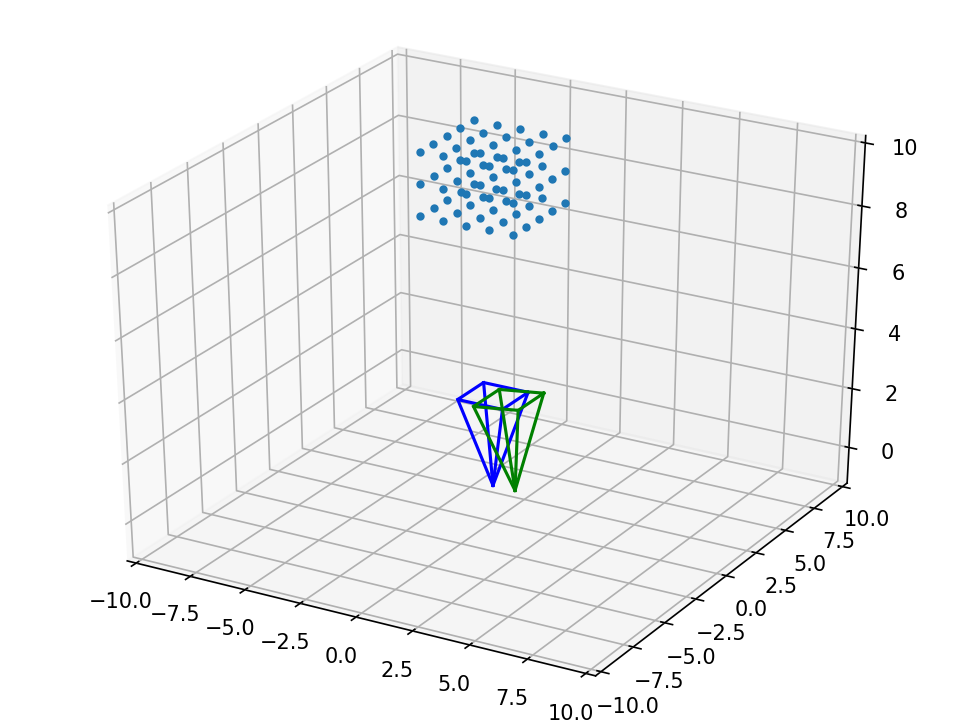

In [5]:
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-1, 10)

plotCamera(ax, R1, t1, "b", 1)
plotCamera(ax, R2_est.T, - R2_est.T @ t2_est, "g", 1)
ax.plot(X_est[0,:], X_est[1,:], X_est[2,:], ".")

fig.show()

## Exercises

1. Add Gaussian noise (e.g. $\mu=0, \sigma=1 \mathrm{px}$) to the 2D observations `x1` and `x2`, and see how the results are degraded.
2. Add outliers to `x1` and `x2`.
3. Introduce distortion correction.
   * Assume distorted observations and distortion coefficients are given.  Rectify the observations as a preprocessing.